In [75]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward= lambda: None
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
    
    def __radd__(self,other):
        return self + other
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"only supporting int/float powers for now"
        out = Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):   # other * self
        return self * other
    
    def __truediv__(self,other):    # self / other
        other = other if isinstance(other,Value) else Value(other)
        return self * other**-1
    
    def __neg__(self):  #-self
        return self * -1
    
    def __sub__(self,other):    #self - other
        other = other if isinstance(other,Value) else Value(other)
        return self + (-other)
    
    def __rsub__(self,other):
        return Value(other) - self
    def tanh(self):
        x = self.data
        t = (math.exp(x * 2) - 1) / (math.exp(x  *  2) + 1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

In [77]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [78]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid,label="{%s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad),shape='record')
        if n._op:
            dot.node(name=uid+n._op,label = n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

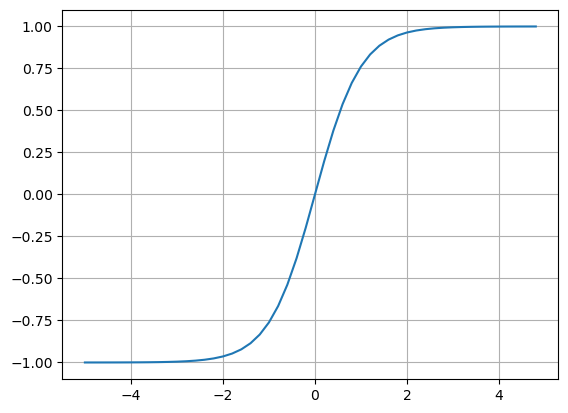

In [79]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid()
plt.show()

In [80]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.8813735870195432,label='b ')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backward()

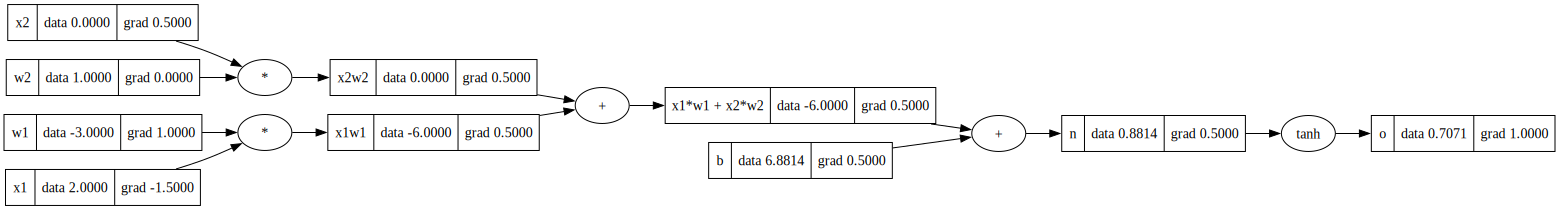

In [81]:
draw_dot(o)

In [82]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.8813735870195432,label='b ')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ------ change the way to calvulate o
e = (2 * n).exp()
o = (e - 1)/(e + 1)
# ------
o.label = 'o'
o.backward()

In [94]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x): # Neoron(x)
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params   #or return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [95]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.453200569427255)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0,-1.0,-1.0,1.0]

[Value(data=0.453200569427255),
 Value(data=0.3528715198498785),
 Value(data=0.5042889326524129),
 Value(data=0.2963083930394616)]

In [ ]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)** 2 for yout,ygt in zip(ys,ypred)])
    # backward pass
    loss.backward()
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k,loss.data)
